In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [89]:
X = np.linspace(0, 1, 10)[:,None]
y = 10*X + 37 + np.random.randn()

with pm.Model() as marginal_gp_model:
    # Specify the covariance function.
    cov_func = pm.gp.cov.ExpQuad(1, ls=1.)

    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.Marginal(cov_func=cov_func)

    # The scale of the white noise term can be provided,
    y_ = gp.marginal_likelihood("y", X=X, y=y.squeeze(), noise=1.0)
    
    y_star = gp.conditional("y_star", Xnew=Xnew)
    
    trace = pm.sample(500, init=pm.find_MAP())

<ipython-input-89-e6afc128ad6a>:16: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(500, init=pm.find_MAP())
Auto-assigning NUTS sampler...


TypeError: init must be a string.

In [ ]:
# vector of new X points we want to predict the function at
X_new = np.linspace(0, 1.5, 100)[:,None]

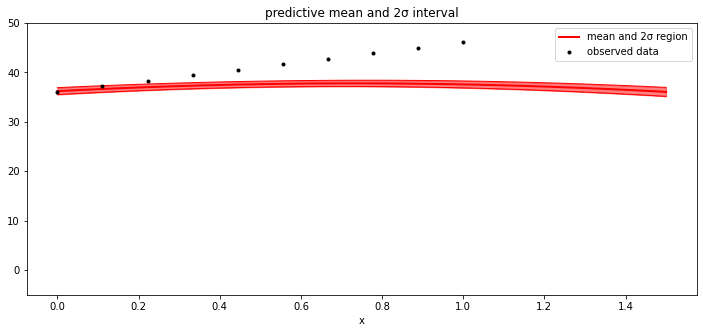

In [86]:
# predict
mu, var = gp.predict(X_new, diag=True)
sd = np.sqrt(var)

# draw plot
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot mean and 2σ intervals
plt.plot(X_new, mu, "r", lw=2, label="mean and 2σ region")
plt.plot(X_new, mu + 2 * sd, "r", lw=1)
plt.plot(X_new, mu - 2 * sd, "r", lw=1)
plt.fill_between(X_new.flatten(), mu - 2 * sd, mu + 2 * sd, color="r", alpha=0.5)

# plot original data and true function
plt.plot(X, y, "ok", ms=3, alpha=1.0, label="observed data")
#plt.plot(X, y_star, "dodgerblue", lw=3, label="true f")

plt.xlabel("x")
plt.ylim([-5, 50])
plt.title("predictive mean and 2σ interval")
plt.legend()
plt.show()

---
# Something different?
<a href="https://pymc3-testing.readthedocs.io/en/rtd-docs/notebooks/GP-slice-sampling.html#Examine-actual-posterior-distribution">See here.</a>

In [107]:
# Number of training points
n = 10
X0 = np.sort(3 * np.random.rand(n))[:, None]

# Number of points at which to interpolate
m = 100
X = np.linspace(0, 3, m)[:, None]

# Covariance kernel parameters
noise = 0.1
lengthscale = 0.3
f_scale = 1

cov = f_scale * pm.gp.cov.ExpQuad(1, lengthscale)
K = cov(X0)
K_s = cov(X0, X)
K_noise = K + noise * np.eye(n)

# Add very slight perturbation to the covariance matrix diagonal to improve numerical stability
K_stable = K + 1e-12 * np.eye(n)

# Observed data
f = np.random.multivariate_normal(mean=np.zeros(n), cov=K_noise.eval())

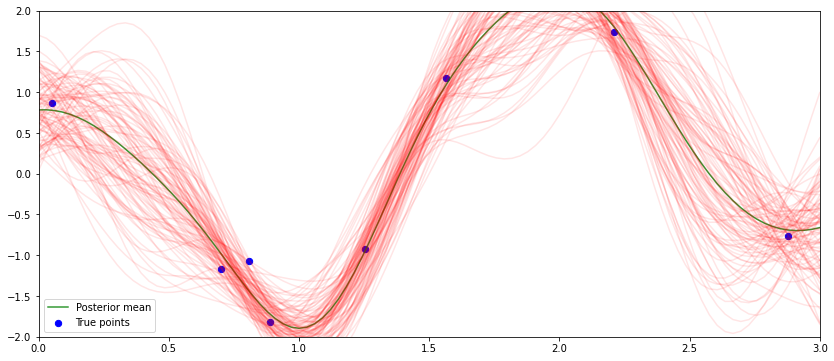

In [127]:
fig, ax = plt.subplots(figsize=(14, 6));
ax.scatter(X0, f, s=40, color='b', label='True points');

# Analytically compute posterior mean
L = np.linalg.cholesky(K_noise.eval())
alpha = np.linalg.solve(L.T, np.linalg.solve(L, f))
post_mean = np.dot(K_s.T.eval(), alpha)

# Analytically compute predictive variance
v = np.linalg.solve(L, K_s.eval())
pred_var = cov(X, X).eval() - np.dot(v.T, v)

ax.plot(X, post_mean, color='g', alpha=0.8, label='Posterior mean');
for _ in range(100):
    preds = np.random.multivariate_normal(mean=post_mean, cov=pred_var)
    ax.plot(X, preds, color='r', alpha=0.1)

ax.set_xlim(0, 3);
ax.set_ylim(-2, 2);
ax.legend();

In [122]:
preds = np.random.multivariate_normal(mean=post_mean, cov=pred_var)

In [125]:
preds

array([ 0.41689522,  0.31669618,  0.21242081,  0.10772902,  0.00571489,
       -0.09118109, -0.18120945, -0.26331033, -0.33708591, -0.40275537,
       -0.46109927, -0.51339586, -0.56134749, -0.60699338, -0.65260383,
       -0.70055078, -0.75315532, -0.81251591, -0.88032936, -0.95772043,
       -1.04509981, -1.14207061, -1.24739702, -1.35904315, -1.47427884,
       -1.58983871, -1.70211265, -1.80734455, -1.90181387, -1.9819844 ,
       -2.04461305, -2.08682087, -2.10613914, -2.10054332, -2.06849164,
       -2.00897026, -1.92154689, -1.80641969, -1.66444624, -1.49713498,
       -1.30659316, -1.09542647, -0.86660538, -0.62331723, -0.36882885,
       -0.10638328,  0.16085624,  0.42981183,  0.69745592,  0.96075545,
        1.21662082,  1.46188036,  1.69330186,  1.90766185,  2.10186531,
        2.27309693,  2.41898825,  2.53777622,  2.62843313,  2.69075299,
        2.72538087,  2.73378337,  2.71816223,  2.68131779,  2.62647656,
        2.5570981 ,  2.4766767 ,  2.38855558,  2.29576788,  2.20